# ---------------------- Hierarchical Claassification using CNN --------------------

## Business Problem/Objective: Build a Deep Learning classification model that takes the hierarchy into consideration.

### Every Data science project will follow CRISP-DM standard. Following are the steps I performed to solve this problem.

### A. Understanding Business problem and Extracting the data (Google Quick Draw Data Set - Extracted from Google Cloud)

### B. Understanding data - exploring Images  

### C. Load and Preprocess the data 1. Prepare the image feature matrix 2. Normalize the data 3. Prepare the target variable

### D. Define the CNN model's Architecture

### E. Train the Model

### F. Make Predictions and Evaluate the model on Test Data

## Note: I mentioned the solution approach before preparing the target variable 

### Import Necessary Libraries

In [1]:
import glob

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score

Using TensorFlow backend.
/Users/gsaitej/anaconda3/lib/python3.6/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.24.1) or chardet (2.3.0) doesn't match a supported version!
  RequestsDependencyWarning)


### File Paths

In [2]:
file_paths = glob.glob('/Users/gsaitej/Downloads/*.npy')

### Load the data

In [3]:
cat = np.load('/Users/gsaitej/Downloads/full_numpy_bitmap_cat.npy')
dog = np.load('/Users/gsaitej/Downloads/full_numpy_bitmap_dog.npy')
car = np.load('/Users/gsaitej/Downloads/full_numpy_bitmap_car.npy')
bus = np.load('/Users/gsaitej/Downloads/full_numpy_bitmap_bus.npy')

### Function to Plot Drawings

In [4]:
def plot_drawings(input_array, rows=4, cols=5, title=''):
    
    '''
    
    Function to plot 28x28 pixel drawings that are stored in a numpy array.
    
    Arguments:
    
    input_array: Numpy array with pixels information of Drawings
    rows: Number of rows in plot grid
    cols: Number of columns in plot grid
    title: Title of the plot grid

    Returns:
    Returns a plot grid (rows x columns) includes drawings of the input array
    
    '''
    
    fig, ax = plt.subplots(figsize=(cols,rows))
    ax.axis('off')
    plt.title(title)

    for i in list(range(0, min(len(input_array),(rows*cols)))):      
        a = fig.add_subplot(rows,cols,i+1)
        imgplot = plt.imshow(input_array[i,:784].reshape((28,28)), cmap='gray_r', interpolation='nearest')
        plt.xticks([])
        plt.yticks([])

### Plotting Sample Cat Drawings

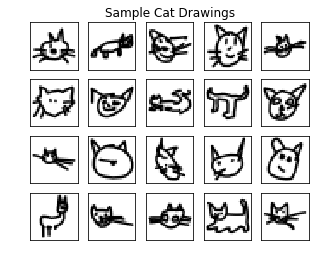

In [5]:
plot_drawings(cat[0:20], title = 'Sample Cat Drawings')

### Plotting Sample Dog Drawings

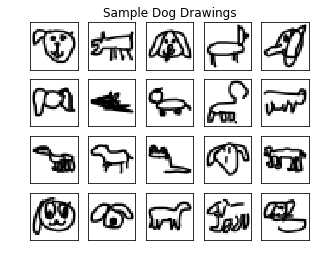

In [6]:
plot_drawings(dog[0:20], title = 'Sample Dog Drawings')

### Plotting Sample Car Drawings

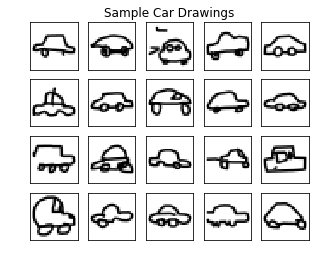

In [7]:
plot_drawings(car[0:20], title = 'Sample Car Drawings')

### Plotting Sample Bus Drawings

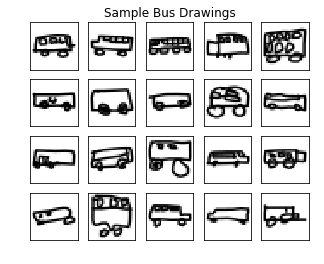

In [8]:
plot_drawings(bus[0:20], title = 'Sample Bus Drawings')

### Randomly Sampling 100 images for each category

In [9]:
cat = cat[np.random.choice(len(cat), 100),:]

dog = dog[np.random.choice(len(dog), 100),:]

car = car[np.random.choice(len(car), 100),:]

bus = bus[np.random.choice(len(bus), 100),:]

### Features Array

In [10]:
X = np.concatenate((cat, dog, car, bus), axis=0)
X = X.reshape(len(X), 28, 28)

## Note: We can perform some image preprocessing techniques on images but since we are working on smaller sample of drawing images. I didn't performed any of the technique. Ideally, we can perform dilation technique (drawing images) or any other suitable morphological operations over here.

### Target/Label Array

In [11]:
y = pd.Series(np.repeat(('cat','dog','car','bus'),100))

In [12]:
y

0      cat
1      cat
2      cat
3      cat
4      cat
5      cat
6      cat
7      cat
8      cat
9      cat
10     cat
11     cat
12     cat
13     cat
14     cat
15     cat
16     cat
17     cat
18     cat
19     cat
20     cat
21     cat
22     cat
23     cat
24     cat
25     cat
26     cat
27     cat
28     cat
29     cat
      ... 
370    bus
371    bus
372    bus
373    bus
374    bus
375    bus
376    bus
377    bus
378    bus
379    bus
380    bus
381    bus
382    bus
383    bus
384    bus
385    bus
386    bus
387    bus
388    bus
389    bus
390    bus
391    bus
392    bus
393    bus
394    bus
395    bus
396    bus
397    bus
398    bus
399    bus
Length: 400, dtype: object

In [13]:
y.value_counts()

car    100
bus    100
cat    100
dog    100
dtype: int64

###  Randomly Split (stratified) the data into train and test 

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X/255.,y,train_size=0.75,random_state=0, stratify=y)

/Users/gsaitej/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [15]:
X_train.shape

(300, 28, 28)

In [16]:
y_train.shape

(300,)

In [17]:
y_train.value_counts()

bus    75
cat    75
dog    75
car    75
dtype: int64

In [18]:
X_test.shape

(100, 28, 28)

In [19]:
y_test.shape

(100,)

In [20]:
y_test.value_counts()

dog    25
car    25
bus    25
cat    25
dtype: int64

## Solution Approach: 

### Since we need to predict the category and it's hierarchy also, I solved this problem using multi label classification approach. So, I prepared the target variable in such a way that each target row has multi labels. For example, we have different multi labels like cat-animals, dog-animals, car-vehicles and bus-vehicles. So each image may belongs to one of the multi lables. Following is the definition of multi-label image classification.

### Each image here belongs to more than one class and hence it is a multi-label image classification problem.

### In case of multi-label image classification, we can have more than one label for a single image. We want the probabilities to be independent of each other. Using the softmax activation function will not be appropriate. Instead, we can use the sigmoid activation function. This will predict the probability for each class independently. It will internally create n models (n here is the total number of classes), one for each class and predict the probability for each class.

### Using sigmoid activation function will turn the multi-label problem to n – binary classification problems. So for each image, we will get probabilities defining whether the image belongs to class 1 or not, and so on. Since we have converted it into a n – binary classification problem, we will use the binary_crossentropy loss. Our aim is to minimize this loss in order to improve the performance of the model.

### Preparing Target for Hierarchical Classification

### Adding animals and vehicles also in target one hot encoded vector

In [21]:
y_train_prep = pd.concat([pd.get_dummies(y_train),
           pd.get_dummies(y_train.map({'cat':'animals', 'dog':'animals', 'car':'vehicles', 'bus':'vehicles'}))],
            axis=1)

In [22]:
y_test_prep = pd.concat([pd.get_dummies(y_test),
           pd.get_dummies(y_test.map({'cat':'animals', 'dog':'animals', 'car':'vehicles', 'bus':'vehicles'}))],
            axis=1)

In [23]:
y_train_prep

,bus,car,cat,dog,animals,vehicles
160,0,0,0,1,1,0
313,1,0,0,0,0,1
307,1,0,0,0,0,1
9,0,0,1,0,1,0
218,0,1,0,0,0,1
55,0,0,1,0,1,0
392,1,0,0,0,0,1
260,0,1,0,0,0,1
269,0,1,0,0,0,1
374,1,0,0,0,0,1


In [24]:
y_train

160    dog
313    bus
307    bus
9      cat
218    car
55     cat
392    bus
260    car
269    car
374    bus
50     cat
170    dog
81     cat
308    bus
125    dog
7      cat
282    car
45     cat
266    car
72     cat
399    bus
279    car
15     cat
302    bus
257    car
22     cat
311    bus
41     cat
36     cat
229    car
      ... 
247    car
233    car
183    dog
357    bus
341    bus
113    dog
219    car
204    car
343    bus
385    bus
299    car
106    dog
236    car
31     cat
60     cat
281    car
216    car
373    bus
231    car
376    bus
17     cat
115    dog
14     cat
328    bus
360    bus
252    car
375    bus
174    dog
96     cat
169    dog
Length: 300, dtype: object

In [25]:
y_test_prep

,bus,car,cat,dog,animals,vehicles
248,0,1,0,0,0,1
116,0,0,0,1,1,0
53,0,0,1,0,1,0
24,0,0,1,0,1,0
119,0,0,0,1,1,0
370,1,0,0,0,0,1
293,0,1,0,0,0,1
171,0,0,0,1,1,0
28,0,0,1,0,1,0
246,0,1,0,0,0,1


In [26]:
y_test

248    car
116    dog
53     cat
24     cat
119    dog
370    bus
293    car
171    dog
28     cat
246    car
100    dog
372    bus
267    car
381    bus
132    dog
259    car
172    dog
210    car
11     cat
364    bus
108    dog
202    car
82     cat
321    bus
223    car
214    car
273    car
124    dog
241    car
203    car
      ... 
61     cat
193    dog
221    car
146    dog
46     cat
262    car
309    bus
3      cat
37     cat
337    bus
163    dog
365    bus
369    bus
27     cat
242    car
187    dog
277    car
86     cat
121    dog
128    dog
173    dog
243    car
344    bus
288    car
383    bus
67     cat
227    car
191    dog
396    bus
167    dog
Length: 100, dtype: object

In [27]:
num_classes = y_train_prep.columns.nunique()

In [28]:
num_classes

6

### Reshape the feature array for CNN

In [29]:
X_train_cnn = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_test_cnn = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')

### CNN Model Architecture

In [30]:
model = Sequential()

model.add(Conv2D(32, kernel_size = (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation = 'sigmoid'))

In [31]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train_cnn, y_train_prep, epochs = 20, batch_size = 16, verbose=1)

Epoch 1/20
300/300 [==============================] - 2s 7ms/step - loss: 0.5585 - acc: 0.7150
Epoch 2/20
300/300 [==============================] - 0s 671us/step - loss: 0.3013 - acc: 0.8928
Epoch 3/20
300/300 [==============================] - 0s 641us/step - loss: 0.1876 - acc: 0.9472
Epoch 4/20
300/300 [==============================] - 0s 627us/step - loss: 0.1032 - acc: 0.9750
Epoch 5/20
300/300 [==============================] - 0s 622us/step - loss: 0.0573 - acc: 0.9922
Epoch 6/20
300/300 [==============================] - 0s 629us/step - loss: 0.0371 - acc: 0.9983
Epoch 7/20
300/300 [==============================] - 0s 643us/step - loss: 0.0216 - acc: 1.0000
Epoch 8/20
300/300 [==============================] - 0s 638us/step - loss: 0.0125 - acc: 1.0000
Epoch 9/20
300/300 [==============================] - 0s 622us/step - loss: 0.0069 - acc: 1.0000
Epoch 10/20
300/300 [==============================] - 0s 615us/step - loss: 0.0044 - acc: 1.0000
Epoch 11/20
300/300 [==========

### Test Accuracy

In [32]:
scores = model.evaluate(X_test_cnn, y_test_prep, verbose=0)
print('CNN accuracy on Test Data: ', scores[1])

CNN accuracy on Test Data:  0.8883333468437195


In [33]:
scores

[0.319856783747673, 0.8883333468437195]

In [34]:
classes = np.array(y_train_prep.columns)

In [35]:
classes

array(['bus', 'car', 'cat', 'dog', 'animals', 'vehicles'], dtype=object)

### Testing on Random 30 images

### Our model is performing decently well on test images

****************************************************************************************************
animals (0.725)
dog (0.711)
vehicles (0.18)

Acutal Category dog


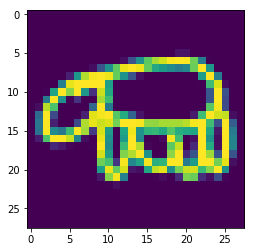

****************************************************************************************************
vehicles (1.0)
car (1.0)
dog (0.000635)

Acutal Category car


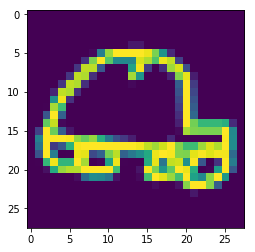

****************************************************************************************************
vehicles (0.978)
bus (0.828)
car (0.0429)

Acutal Category bus


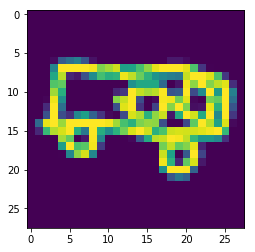

****************************************************************************************************
vehicles (1.0)
bus (0.916)
car (0.0986)

Acutal Category bus


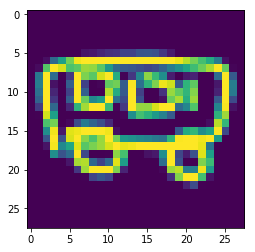

****************************************************************************************************
animals (0.99)
dog (0.957)
cat (0.013)

Acutal Category dog


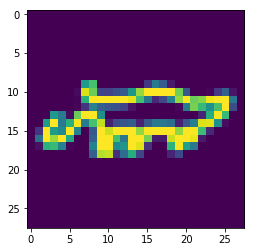

****************************************************************************************************
vehicles (1.0)
bus (0.999)
dog (0.00143)

Acutal Category bus


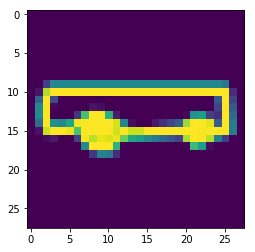

****************************************************************************************************
animals (0.547)
vehicles (0.328)
cat (0.176)

Acutal Category cat


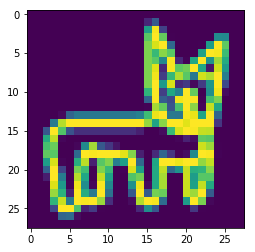

****************************************************************************************************
animals (0.95)
dog (0.808)
vehicles (0.0699)

Acutal Category dog


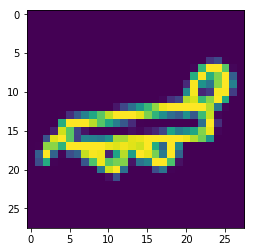

****************************************************************************************************
car (0.997)
vehicles (0.994)
dog (0.0161)

Acutal Category car


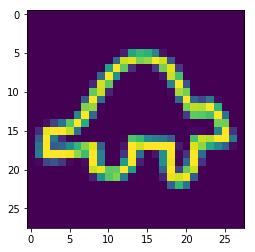

****************************************************************************************************
bus (1.0)
vehicles (1.0)
animals (0.000175)

Acutal Category bus


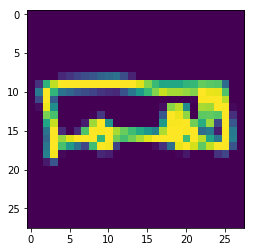

****************************************************************************************************
animals (0.568)
dog (0.446)
vehicles (0.233)

Acutal Category dog


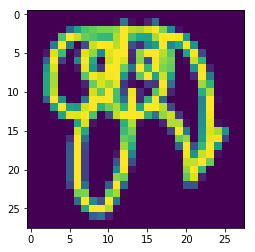

****************************************************************************************************
animals (1.0)
cat (0.926)
dog (0.0643)

Acutal Category cat


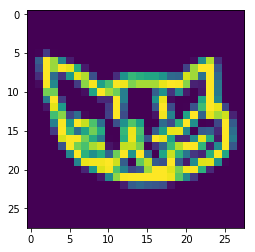

****************************************************************************************************
vehicles (0.859)
car (0.801)
animals (0.179)

Acutal Category car


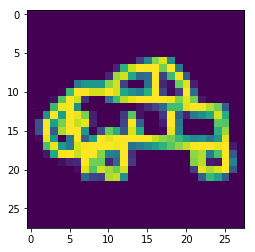

****************************************************************************************************
animals (0.996)
cat (0.374)
dog (0.351)

Acutal Category cat


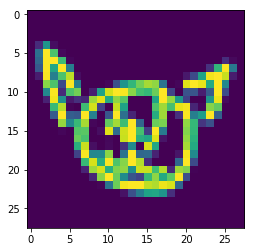

****************************************************************************************************
animals (1.0)
cat (0.926)
dog (0.0643)

Acutal Category cat


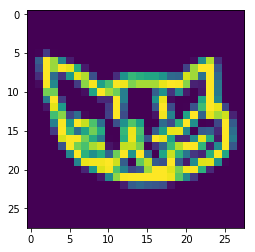

****************************************************************************************************
animals (0.978)
cat (0.485)
dog (0.267)

Acutal Category cat


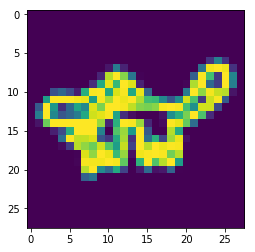

****************************************************************************************************
animals (0.999)
cat (0.994)
car (0.00274)

Acutal Category cat


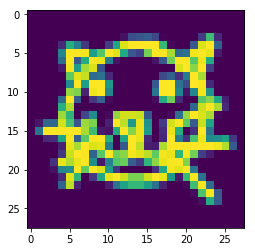

****************************************************************************************************
vehicles (0.999)
car (0.979)
bus (0.0183)

Acutal Category car


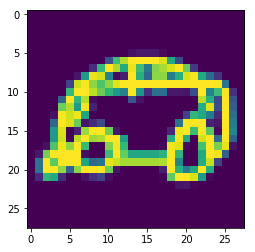

****************************************************************************************************
vehicles (0.697)
dog (0.586)
animals (0.448)

Acutal Category dog


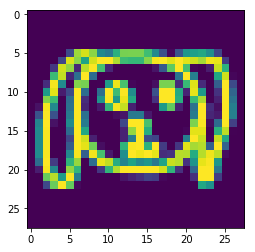

****************************************************************************************************
vehicles (1.0)
car (1.0)
dog (0.000635)

Acutal Category car


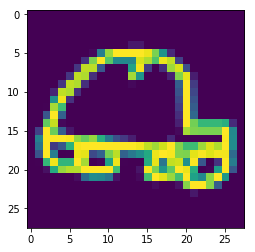

****************************************************************************************************
animals (0.95)
cat (0.921)
dog (0.0513)

Acutal Category dog


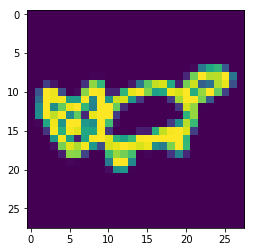

****************************************************************************************************
animals (0.655)
cat (0.548)
bus (0.409)

Acutal Category dog


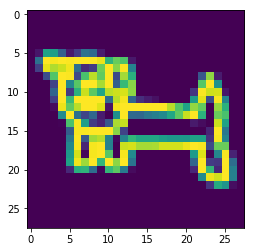

****************************************************************************************************
animals (0.993)
cat (0.732)
dog (0.153)

Acutal Category bus


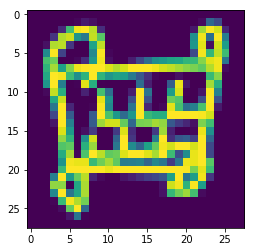

****************************************************************************************************
vehicles (0.748)
bus (0.625)
animals (0.296)

Acutal Category cat


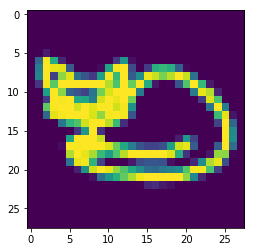

****************************************************************************************************
bus (0.858)
vehicles (0.79)
cat (0.142)

Acutal Category bus


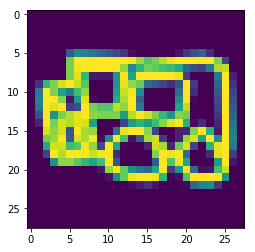

****************************************************************************************************
animals (0.667)
dog (0.375)
vehicles (0.221)

Acutal Category dog


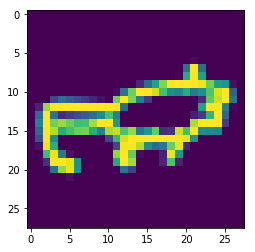

****************************************************************************************************
animals (0.999)
cat (0.994)
car (0.00274)

Acutal Category cat


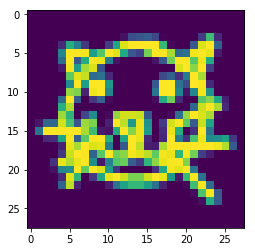

****************************************************************************************************
animals (0.993)
cat (0.355)
dog (0.216)

Acutal Category cat


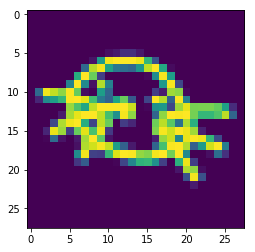

****************************************************************************************************
animals (1.0)
dog (0.998)
cat (0.00105)

Acutal Category dog


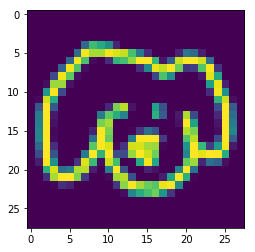

****************************************************************************************************
vehicles (0.998)
bus (0.989)
cat (0.00946)

Acutal Category car


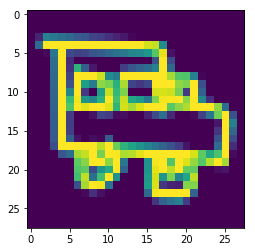

In [36]:
random_test_samples = np.random.choice(len(X_test), 30)
for samp_indx in random_test_samples:
    print('*'*100)
    proba = model.predict(X_test[samp_indx].reshape(1,28,28,1))
    top_3 = np.argsort(proba[0])[:-4:-1]
    for i in range(3):
        print("{}".format(classes[top_3[i]])+" ({:.3})".format(proba[0][top_3[i]]))

    print('\nAcutal Category', y_test.iloc[samp_indx])
    plt.imshow(X_test[samp_indx])
    plt.show()

## Conclusion: Our model performance is purely depends on number of images we are having for each multi label. If we can maintain the same data distribution for all multi labels. We will get some good results.

## -------------------------------------------- Next Steps --------------------------------------------

## Whatever I followed here is basic approach, we can try and experiment different approaches to solve this problem. One of the approach is using Keras API (normally we will use this for transfer learning), we can define two different outputs for the category and it's hierarchy. So one of the output we will predict the hierarchy and in another output we will predict the category.